# Predicting the Rating

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, roc_auc_score, precision_score, recall_score, roc_curve, PrecisionRecallDisplay,precision_recall_curve
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier 
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor, XGBClassifier

Import the scraped and processed data. The reduced_features excludes the key word features, this is used for comparison.

In [2]:
df_train=pd.read_csv('df_train.csv',index_col=0)
df_test=pd.read_csv('df_test.csv',index_col=0)

X_train=df_train.drop('rating',axis=1)
y_train=df_train['rating']

X_test=df_test.drop('rating',axis=1)
y_test=df_test['rating']

reduced_features=['dist','ascent_original','corbett_original','munro_original','grade_original','bog_original','region_aberdeenshire',
 'region_angus','region_argyll','region_arran','region_cairngorms','region_fortwilliam','region_islands','region_islay-jura',
 'region_kintail','region_lochlomond','region_lochness','region_moray','region_mull','region_orkney','region_outer-hebrides',
 'region_perthshire','region_shetland','region_skye','region_sutherland','region_torridon','region_ullapool']

X_train_reduced=X_train[reduced_features]
X_test_reduced=X_test[reduced_features]


# Regression Approach

Dummy Regressor as a benchmark

In [3]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
y_predict_train=dummy_regr.predict(X_train)
y_predict=dummy_regr.predict(X_test)

print('train_error:',mean_squared_error(y_predict_train,y_train,squared=False))
print('test_error:',mean_squared_error(y_predict,y_test,squared=False))

train_error: 0.5775009941808824
test_error: 0.5863082156825604


Create Piplines:

In [4]:
pipelines={
    'rf': make_pipeline(RandomForestRegressor()),
    'xgb': make_pipeline(XGBRegressor())
}

In [5]:
for feats, train, test in [['Key Words used:',X_train,X_test],
                                  ['Key Words not used:',X_train_reduced,X_test_reduced]]:
    print(feats)
    for name, estimator in pipelines.items():
        estimator.fit(train,y_train)
        y_predict_train=estimator.predict(train)
        y_predict=estimator.predict(test)

        train_error=mean_squared_error(y_predict_train,y_train,squared=False)
        test_error=mean_squared_error(y_predict,y_test,squared=False)
        print(name, train_error,test_error)

Key Words used:
rf 0.20266127295501624 0.5360910718875226
xgb 0.08241249107392869 0.5624033976531516
Key Words not used:
rf 0.2190843658530786 0.5915834282255948
xgb 0.16981489163998792 0.6652050347082112


We can see here that the key words are improving the models but niether are outperforming the dummy by any significant degree. 

## Hyperparameter tuning

In [6]:
#grids are commented out to save run time 
rf_params={'randomforestregressor__n_estimators':[200],#[100,200],
           'randomforestregressor__max_depth':[6],#[5,6],
           'randomforestregressor__max_leaf_nodes':[30],#[20,30],
           'randomforestregressor__min_samples_split':[2],#[2,5,10],
           'randomforestregressor__min_samples_leaf':[5],#[1,5,10],
          'randomforestregressor__random_state':[0]}




xgb_params={'xgbregressor__eta': [0.1],#[0.1,0.15],
           'xgbregressor__max_depth':[2],#[2,3,4],
           'xgbregressor__min_child_weight':[10],#[1,5,10],
           'xgbregressor__lambda':[1],#[1,5,10],
           'xgbregressor__alpha':[0]#[0,1,5]
           }

param_grid={'rf':rf_params,
           'xgb':xgb_params}

In [7]:
tuned_models={}

for name, estimator in pipelines.items():
    print('fitting',name)
    tuned_model=GridSearchCV(estimator,param_grid=param_grid[name],scoring='neg_root_mean_squared_error')
    tuned_model.fit(X_train, y_train)
    tuned_models[name]=tuned_model

fitting rf
fitting xgb


In [8]:
for name, model in tuned_models.items():
    y_predict_train=tuned_models[name].predict(X_train)
    y_predict=tuned_models[name].predict(X_test)
    train_error=mean_squared_error(y_predict_train,y_train,squared=False)
    test_error=mean_squared_error(y_predict,y_test,squared=False)
    print(name,train_error,test_error)
        

rf 0.4869182591929581 0.5463042835930123
xgb 0.42867997262933466 0.5297117585362126


In [9]:
for name, model in tuned_models.items():
    print(name, model.best_params_)

rf {'randomforestregressor__max_depth': 6, 'randomforestregressor__max_leaf_nodes': 30, 'randomforestregressor__min_samples_leaf': 5, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 200, 'randomforestregressor__random_state': 0}
xgb {'xgbregressor__alpha': 0, 'xgbregressor__eta': 0.1, 'xgbregressor__lambda': 1, 'xgbregressor__max_depth': 2, 'xgbregressor__min_child_weight': 10}


# Classification Approach

## MultiClass Case

Here we are trying to identify which of 5 classes the data sits in (ratings 1-2, 2-3, 3-4, 4-5). We can see we have more sucess here than with regression but it is still worth simplifying the task.

In [10]:
y_train_class=pd.read_csv('y_train_class.csv',index_col=0).to_numpy().reshape(-1,)
y_test_class=pd.read_csv('y_test_class.csv',index_col=0).to_numpy().reshape(-1,)

In [11]:
pipelines_class={
    'rf_class': make_pipeline(RandomForestClassifier()),
    'xgb_class': make_pipeline(XGBClassifier())
}

In [12]:
for feats, train, test in [['Key Words used:',X_train,X_test],
                                  ['Key Words not used:',X_train_reduced,X_test_reduced]]:
    print(feats)
    for name, classifier in pipelines_class.items():
        classifier.fit(train,y_train_class)
        y_predict_train=classifier.predict_proba(train)
        y_predict=classifier.predict_proba(test)

        print(name, roc_auc_score(y_train_class, y_predict_train, multi_class='ovr'),
              roc_auc_score(y_test_class, y_predict, multi_class='ovr'))
    

Key Words used:
rf_class 1.0 0.6378198342159639
xgb_class 1.0 0.6353970068858424
Key Words not used:
rf_class 1.0 0.6137033174238818
xgb_class 0.99941563370989 0.6176182778034898


In [13]:
rf_params={'randomforestclassifier__n_estimators':[100,200],
           'randomforestclassifier__max_depth':[2,3,4],
           'randomforestclassifier__max_leaf_nodes':[10,20],
           'randomforestclassifier__min_samples_split':[2,5,10],
           'randomforestclassifier__min_samples_leaf':[1,5,10],
          'randomforestclassifier__random_state':[0]}




xgb_params={'xgbclassifier__eta': [0.1,0.2],
           'xgbclassifier__max_depth':[2,3,4],
           'xgbclassifier__min_child_weight':[1,5],
           'xgbclassifier__reg_lambda':[1,5,10],
           'xgbclassifier__reg_alpha':[0,5,10]
           }

param_grid={'rf_class':rf_params,
           'xgb_class':xgb_params}

In [14]:
tuned_classifiers={}
for name, classifier in pipelines_class.items():
    print('fitting',name)
    tuned_model=GridSearchCV(classifier,param_grid=param_grid[name],scoring='roc_auc_ovr')
    tuned_model.fit(X_train, y_train_class)
    tuned_classifiers[name]=tuned_model

fitting rf_class
fitting xgb_class


In [15]:
for name, classifier in tuned_classifiers.items():
    #estimator.fit(X_train,y_train_class)
    y_predict_train=classifier.predict_proba(X_train)
    y_predict=classifier.predict_proba(X_test)

    print(name, roc_auc_score(y_train_class, y_predict_train, multi_class='ovr'),
          roc_auc_score(y_test_class, y_predict, multi_class='ovr'))

rf_class 0.812608767140666 0.639125849531725
xgb_class 0.917377919685924 0.6466403045664879


In [16]:
print(tuned_classifiers['rf_class'].best_params_)
print(tuned_classifiers['xgb_class'].best_params_)

{'randomforestclassifier__max_depth': 4, 'randomforestclassifier__max_leaf_nodes': 10, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__random_state': 0}
{'xgbclassifier__eta': 0.1, 'xgbclassifier__max_depth': 2, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__reg_alpha': 0, 'xgbclassifier__reg_lambda': 1}


## Binary Case

Now we are only attempting to classify walks based on whether the rating is greater or less than 4, we have more succes. 

In [17]:
y_train_binary=pd.read_csv('y_train_binary.csv',index_col=0).to_numpy().reshape(-1,)
y_test_binary=pd.read_csv('y_test_binary.csv',index_col=0).to_numpy().reshape(-1,)


In [18]:
pipelines_binary={
    'rf_class': make_pipeline(RandomForestClassifier()),
    'xgb_class': make_pipeline(XGBClassifier())}

In [19]:
for feats, train, test in [['Key Words used:',X_train,X_test],
                                  ['Key Words not used:',X_train_reduced,X_test_reduced]]:
    print(feats)

    for name, classifier in pipelines_binary.items():
        classifier.fit(train,y_train_binary)
        y_predict_train=classifier.predict_proba(train)[:, 1]
        y_predict=classifier.predict_proba(test)[:, 1]
        #print(y_predict_train)

        print(name, roc_auc_score(y_train_binary, y_predict_train),roc_auc_score(y_test_binary, y_predict))

Key Words used:
rf_class 1.0 0.6862499502962346
xgb_class 0.9999918750710931 0.6915185494453059
Key Words not used:
rf_class 1.0 0.6458706111575012
xgb_class 0.9938880222298054 0.6608016223309078


In [20]:
rf_params={'randomforestclassifier__n_estimators':[100,200],
           'randomforestclassifier__max_depth':[2,3],
           'randomforestclassifier__max_leaf_nodes':[10,20],
           'randomforestclassifier__min_samples_split':[2,5],
           'randomforestclassifier__min_samples_leaf':[1,5],
          'randomforestclassifier__random_state':[0]}




xgb_params={'xgbclassifier__eta': [0.1,0.15],
           'xgbclassifier__max_depth':[2,3],
           'xgbclassifier__min_child_weight':[1,5],
           'xgbclassifier__reg_lambda':[1,5],
           'xgbclassifier__reg_alpha':[0,1]
           }

param_grid={'rf_class':rf_params,
           'xgb_class':xgb_params}

In [23]:
tuned_classifiers={}
for name, classifier in pipelines_binary.items():
    print('fitting',name)
    tuned_model=GridSearchCV(classifier,param_grid=param_grid[name],scoring='roc_auc')
    tuned_model.fit(X_train, y_train_binary)
    tuned_classifiers[name]=tuned_model

fitting rf_class
fitting xgb_class


In [24]:
for name, classifier in tuned_classifiers.items():
    #estimator.fit(X_train,y_train_class)
    y_predict_train=classifier.predict_proba(X_train)[:, 1]
    y_predict=classifier.predict_proba(X_test)[:, 1]

    print(name, roc_auc_score(y_train_binary, y_predict_train),
          roc_auc_score(y_test_binary, y_predict))
    

rf_class 0.8147475584588635 0.676010974591435
xgb_class 0.8558596987276362 0.7023738518430156


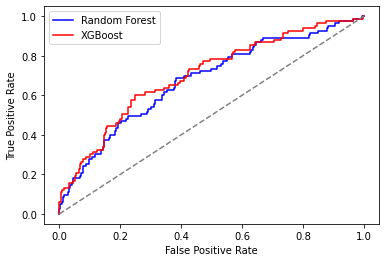

In [29]:
colors={'rf_class':'b','xgb_class':'r'}
for name, classifier in tuned_classifiers.items():
    #estimator.fit(X_train,y_train_class)
    y_predict=classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, threshold=roc_curve(y_test_binary, y_predict)
    #roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr,colors[name])
    #plt.title('Random forrest vs XGBoost')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(['Random Forest','XGBoost'])
plt.plot([0, 1], [0, 1],'--',color='grey')
plt.show()

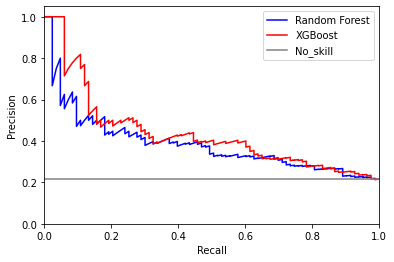

In [28]:
no_skill=len(y_test_binary[y_test_binary==1])/len(y_test_binary)
colors={'rf_class':'b','xgb_class':'r'}

plt.figure()

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

for name, classifier in tuned_classifiers.items():
    precision, recall, _ = precision_recall_curve(y_test_binary,classifier.predict_proba(X_test)[:, 1])
    plt.plot(recall,precision,color=colors[name])
    
plt.plot([0,1],[no_skill,no_skill],label='No Skill', color='grey')
plt.legend(['Random Forest','XGBoost','No_skill'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()